# Training on varied events

The toy example consists of two Gaussian clouds in a three dimension space. The two clouds have
 - high seperation in $x$ direction,
 - moderation sepration in $y$ direction and
 - no sepration in $z$ direction.
 
The systematic variation of the sample affects only the $x$ variable. On the varied dataset, $x$ losses all its seperation power.

![Scheme](scheme.png)

## Definitions

In [1]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from IPython.display import HTML, display
import tabulate

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

np.random.seed(31415)  # Nothing-up-my-sleeve number, decimal representation of pi
from tensorflow import set_random_seed
set_random_seed(31415)

Using TensorFlow backend.


## Input variables

In [2]:
def generate(n=1, f_signal=0.5, signal_weight=0.1,  var_weight=1):
    """
    Generates a pandas Dataframe with an arbitrary number of events. The
    Dataframe includes the feature columns x, y and z; the truth
    columns is_signal, is_background and is_variation; as well as a weight
    column.
    
    All arguments are optional. The first argument specifies the number of
    events to generate. The f_signal argument specifies the fraction of raw
    events in the Dataframe that should belong to the signal class. The
    signal_weight argument specifies the weight of a signal event. The product
    of signal_weight and f_signal is the weighted fraction of signal events.
    
    For every generated event (n-many), a up-varied and a down-varied event is
    generated. The returned dataframe contains 3*n entries. The weight of varied
    events is multiplied by var_weight.
    """
    # Draw truth values
    is_signal = (np.random.uniform(size=n) < f_signal)
    is_background = ~is_signal
    
    # Compute event weights
    weight = signal_weight * is_signal
    
    # Draw x, y and z values
    x_up = np.random.normal(loc=50 - 15 * is_background, scale=5)
    x = x_up + np.random.normal(loc=0, scale=math.sqrt(10**2 - 5**2), size=n)
    x_down = x_up + np.random.normal(loc=0, scale=math.sqrt(20**2 - 5**2), size=n)
    
    y = np.random.normal(loc=35 + 10 * is_signal, scale=10)
    z = np.random.normal(loc=0, scale=3, size=n)
    
    noise = np.random.normal(loc=0, scale=30, size=n)
    
    return pd.DataFrame({
        'is_signal': np.concatenate([is_signal] * 3),
        'is_background': np.concatenate([is_background] * 3),
        'is_variation': np.concatenate([np.zeros(n, dtype='bool'),
                                        np.ones(n, dtype='bool'),
                                        np.ones(n, dtype='bool')]),
        'is_up': np.concatenate([np.zeros(n, dtype='bool'),
                                 np.zeros(n, dtype='bool'),
                                 np.ones(n, dtype='bool')]),
        'is_down': np.concatenate([np.zeros(n, dtype='bool'),
                                   np.ones(n, dtype='bool'),
                                   np.zeros(n, dtype='bool')]),
        'weight': np.concatenate([weight,
                                  weight * var_weight,
                                  weight * var_weight]),
        'x': np.concatenate([x, x_down, x_up]),
        'y': np.concatenate([y, y, y]),
        'z': np.concatenate([z, z, z]),
    })
    

In [3]:
# Generate 40k events to plot the input distributions
toy_df = generate(40000)

In [4]:
# Color palette used for several plots in the notebook
col = sns.color_palette()

def variable_plot(variable, bins):
    """
    Plots the given variable of the global toy_df in a histogram. The bins
    argument is directly passed to matplotlib.
    """
    plt.clf()
    col = sns.color_palette()
    # Nominal: Backgrond and Signal
    plt.hist(toy_df[variable][~toy_df.is_signal & ~toy_df.is_variation],
             alpha=0.4, bins=bins, color=col[0])
    plt.hist(toy_df[variable][toy_df.is_signal & ~toy_df.is_variation],
             alpha=0.4, bins=bins, color=col[1])
    
    # Down: Backgrond and Signal
    plt.hist(toy_df[variable][~toy_df.is_signal & toy_df.is_down],
             histtype='step', bins=bins, color=col[0],
             linestyle='--')
    plt.hist(toy_df[variable][toy_df.is_signal & toy_df.is_down],
             histtype='step', bins=bins, color=col[1],
             linestyle='--')
    
    # Up: Backgrond and Signal
    plt.hist(toy_df[variable][~toy_df.is_signal & toy_df.is_up],
             histtype='step', bins=bins, color=col[0],
             linestyle='-.')
    plt.hist(toy_df[variable][toy_df.is_signal & toy_df.is_up],
             histtype='step', bins=bins, color=col[1],
             linestyle='-.')
    
    # Build legend
    leg_bkg = Patch(facecolor=col[0], alpha=0.4, label='Background')
    leg_sig = Patch(facecolor=col[1], alpha=0.4, label='Signal')
    leg_up = Line2D([0], [0], color='black', linestyle='-.', label="1-Up")
    leg_down = Line2D([0], [0], color='black', linestyle='--', label="1-Down")
    plt.legend(handles=[leg_sig, leg_bkg, leg_up, leg_down])
    
    plt.xlabel("$%s$" % variable)
    plt.ylim((0, plt.ylim()[1] * 1.5))
    plt.ylabel("Events / Bin")
    plt.tight_layout()
    plt.savefig("variable_%s.pdf" % variable)
    

The variable $x$ shows the highest discimination power between signal and background for events from the nominal PDF. The sytematic variation affects the background substanially, smears both classes signal and backgrond.

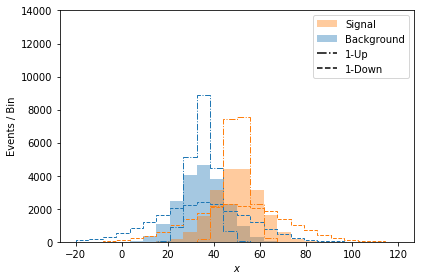

In [5]:
variable_plot("x", np.linspace(-20, 120, 25))

The variable $y$ has a moderate discrimination power between signal background. Neither the signal or background distribution is affacted by the systematic variation, therefore the shaded area and the area enclosed by the dash-dotted line are identical within statistical uncertainties.

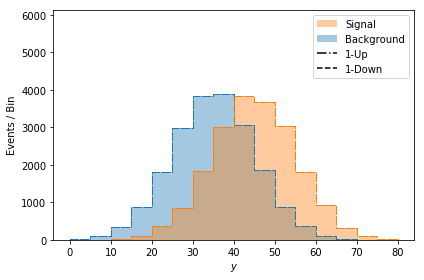

In [6]:
variable_plot("y", np.linspace(0, 80, 17))

The variable $z$ is drawn from a PDF which is independent of the event classes (signal, background) and the variation. All distributions are centered around zero with the same width.

In [7]:
variable_plot("z", np.linspace(-10, 10, 11))

In [8]:
def get_normalization(dataframe):
    """
    Compute moments of the columns of the input dataframe. The method returns
    the mean and the standard deviation. The return value is intended as an
    argument of `normalize()`.
    """
    shift = dataframe.mean()
    shifted = dataframe - dataframe.mean()
    return shift, shifted.std()

def normalize(dataframe, shift, width):
    """
    Applies the normalization. This means the dataframe is shifted to zero-mean
    and scaled to unit-width. The transformed dataframe is returned.
    """
    return (dataframe - shift) / width

## Training: NomModel

The classifier *NomModel* is trained only on the nominal samples. The input variables are $x$, $y$ and $z$. The target of the classifier are the event classes *signal* or *background*. 

In [9]:
def visualize_history(history, model_name):
    """
    Takes the object returned by the fit() method of any Keras model and plots
    the loss and accuracy on the training and validation sets.
    
    The model_name is required to generate a filename for the plot.
    """
    # Plot loss and accuracy on training and validation sets
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Training", color=col[2])
    plt.plot(history.history['val_loss'], label="Validation", color=col[3])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim((0, 1))
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('acc', history.history.get("accuracy", None)), label="Training", color=col[2])
    plt.plot(history.history.get('val_acc', history.history.get("accuracy", None)), label="Validation", color=col[3])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.savefig("loss_acc_%s.pdf" % model_name)

In [10]:
# List of dataframe columns to use as input
input_var = ['x', 'y', 'z']

# Defintion of model
def mk_model():
    model = Sequential()
    model.add(Dense(units=12, activation='relu', input_dim=len(input_var)))
    model.add(Dense(units=2, activation='softmax'))

    # Optimizer (reused for VarModel)
    sgd_optim = SGD(lr=0.01)

    # Model compilation
    model.compile(loss='categorical_crossentropy',
                     optimizer=sgd_optim,
                     metrics=['accuracy'])
    return model

nommodel = mk_model()

N = 50000  # Total number of events used during training

# Prepare training and validation set
df = generate(N)  # Include varied events here ...
df = df[~df.is_variation]    # ... and cut them away here
in_df = df[input_var]
out_df = df[['is_signal', 'is_background']]

# Compute input normalization moments for NomModel classifier
nommodel_norm = get_normalization(in_df)
in_df = normalize(in_df, *nommodel_norm)

# Actual training
history = nommodel.fit(in_df, out_df, validation_split=0.5, epochs=5, batch_size=16, verbose=0)
visualize_history(history, "nommodel")

# Package model and normalization moments for future use
nommodel = (nommodel, nommodel_norm)

## Training: VarModel

The classifier *VarModel* is trained on the nominal and varied events. The input variables are $x$, $y$ and $z$. The target of the classifier are the event classes *signal* or *background*. 

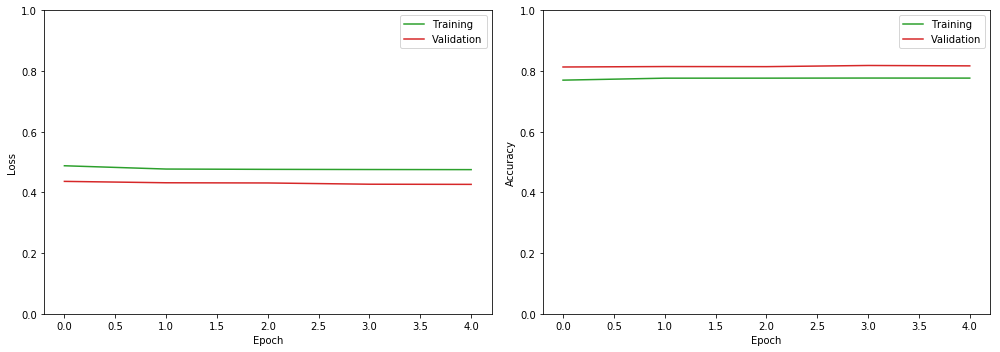

In [11]:
# Create identical model
varmodel = mk_model()

# Prepare training and validation dataset
df = generate(N)  # Half of the events are varied events
in_df = df[input_var]
out_df = df[['is_signal', 'is_background']]

# Compute input normalization moments for NomModel classifier
varmodel_norm = get_normalization(in_df)
in_df = normalize(in_df, *varmodel_norm)

# Actual training
history = varmodel.fit(in_df, out_df, validation_split=0.5, epochs=5, batch_size=16, verbose=0)
visualize_history(history, "varmodel")

# Package model and normalization moments for future use
varmodel = (varmodel, varmodel_norm)

## Training: VarModelWeighted

The classifier *VarModelWeighted* is trained on the nominal and varied events. The input variables are $x$, $y$ and $z$. The target of the classifier are the event classes *signal* or *background*. In constrast to VarModel, VarModelWeighted has a different input event composition. The number of varied events is defined by the 1-sigma level of a Gaussian.

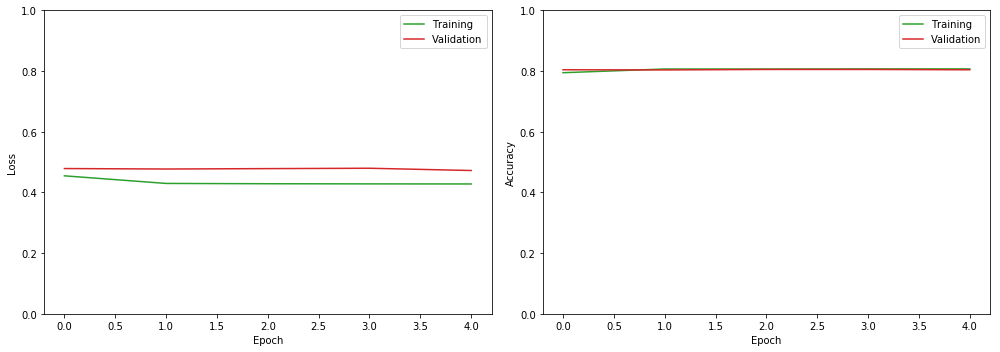

In [12]:
# Create identical model
varmodelw = mk_model()

# Prepare training and validation dataset
df = generate(N)  # Half of the events are varied events

def gaussian(x):
    """
    Not normalized gaussion distribution, centered around zero with unit width.
    """
    return np.exp(-0.5 * x**2)

up_fraction = gaussian(1) / gaussian(0)  # Number of up events relative to nominal
down_fraction = gaussian(1) / gaussian(0)

df['random'] = np.random.rand(len(df))
df = df[(~df.is_variation) | (df.random < up_fraction)]    # ... and cut them away here
in_df = df[input_var]
out_df = df[['is_signal', 'is_background']]

# Compute input normalization moments for NomModel classifier
varmodelw_norm = get_normalization(in_df)
in_df = normalize(in_df, *varmodelw_norm)

# Actual training
history = varmodelw.fit(in_df, out_df, validation_split=0.5, epochs=5, batch_size=16, verbose=0)
visualize_history(history, "varmodel weighted")

# Package model and normalization moments for future use
varmodelw = (varmodelw, varmodelw_norm)

## Output shape

The output of the two classifiers is visualized with a new set of independend events. The fraction of signal events is reduced to 5%. The nominal sample and the varied sample are of the same size on average.

In [13]:
test_df = generate(100000, f_signal=0.05)

In [14]:
def draw_response(df, model):
    """
    Visualizes the output of the given classifier. The plot includes the signal,
    the nominal background and the varied background. The model argument must be
    a tuple of the actual keras model and the normalization moments. This method
    selects the input variables based on the global 'input_var' variables and
    normalizes the inputs.
    
    The model_name is required to gerneate the filename of the plot.
    """
    # Extract model and normalization moments
    model, model_norm = model

    # Apply normalization
    in_df = df[input_var]
    in_df = normalize(in_df, *model_norm)
    
    bins = np.linspace(0, 1, 21)
    
    # Nominal
    plt.hist([model.predict(in_df[df.is_signal & ~df.is_variation]).transpose()[0]],
             alpha=0.4, bins=bins, density=True, label="Signal", color=col[1])
    plt.hist([model.predict(in_df[df.is_background & ~df.is_variation]).transpose()[0]],
             alpha=0.4, bins=bins, density=True, label="Backgound", color=col[0])
    
    # Up
    plt.hist([model.predict(in_df[df.is_signal & df.is_up]).transpose()[0]],
             histtype='step', bins=bins, density=True, linestyle="-.", color=col[1])
    plt.hist([model.predict(in_df[df.is_background & df.is_up]).transpose()[0]],
             histtype='step', bins=bins, density=True, linestyle="-.", color=col[0])
    
    # Down
    plt.hist([model.predict(in_df[df.is_signal & df.is_down]).transpose()[0]],
             histtype='step', bins=bins, density=True, linestyle="--", color=col[1])
    plt.hist([model.predict(in_df[df.is_background & df.is_down]).transpose()[0]],
             histtype='step', bins=bins, density=True, linestyle="--", color=col[0])
    
    
    # Build legend
    leg_bkg = Patch(facecolor=col[0], alpha=0.4, label='Background')
    leg_sig = Patch(facecolor=col[1], alpha=0.4, label='Signal')
    leg_up = Line2D([0], [0], color='black', linestyle='-.', label="1-Up")
    leg_down = Line2D([0], [0], color='black', linestyle='--', label="1-Down")
    plt.legend(handles=[leg_sig, leg_bkg, leg_up, leg_down])
    
    plt.yscale('log')
    plt.xlabel("NN Output")
    plt.ylabel("Events (a.u.)")
    plt.ylim((plt.ylim()[0], plt.ylim()[1] * 15))
    plt.xlim((0, 1))
    plt.tight_layout()

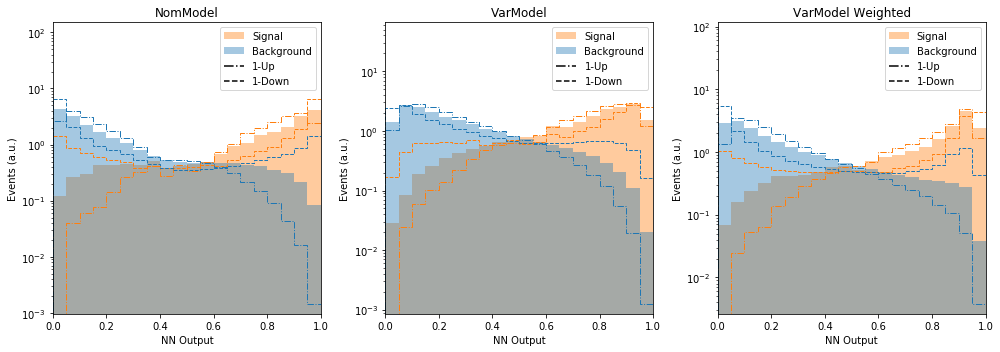

In [15]:
# Plot the response of the classfieres
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
draw_response(test_df, nommodel)
plt.title("NomModel")

plt.subplot(1, 3, 2)
plt.title("VarModel")
draw_response(test_df, varmodel)

plt.subplot(1, 3, 3)
plt.title("VarModel Weighted")
draw_response(test_df, varmodelw)

plt.savefig("response.pdf")

## ROC Curves

In [16]:
def roc(test_df, nommodel, varmodel, varmodelw, steps=100):
    """
    Plot ROC curve. Draws the ROC curve for nominal, 1-up and 1-down.
    
    Code borrowed from
    https://gitlab.cern.ch/fsauerbu/nnfwtbn/blob/master/nnfwtbn/plot.py
    """
    main_loop = [
        (nommodel, col[2], "NomModel"),
        (varmodel, col[3], "VarModel"),
        (varmodelw, col[4], "VarModel Weighted"),
    ]
    
    # Loop over both models
    for model, color, label in main_loop:
        model, model_norm = model
        
        selectors = [
            ('-', lambda df: ~df.is_variation),
            ('-.', lambda df: df.is_up),
            ('--', lambda df: df.is_down),
        ]

        # Loop over data sets
        for line_style, selector in selectors:
            # Apply normalization
            df = test_df[selector(test_df)]
            in_df = df[input_var]
            in_df = normalize(in_df, *model_norm)

            signal_effs = []
            background_ieffs = []

            prediction = model.predict(in_df).transpose()[0]

            n_total_sig = df.is_signal.sum()
            n_total_bkg = df.is_background.sum()

            min = prediction.min()
            max = prediction.max()
            
            # Loop over cut values
            for cut_value in np.linspace(min, max, steps):
                residual_df = df[prediction >= cut_value]

                n_total = len(residual_df)
                if n_total == 0:
                    continue

                n_signal = residual_df.is_signal.sum()
                n_background = residual_df.is_background.sum()

                signal_effs.append(n_signal / n_total_sig)
                background_ieffs.append(1 - n_background / n_total_bkg)

            plt.plot(signal_effs, background_ieffs,
                     label=label, color=color, linestyle=line_style)
            
    plt.xlabel("Signal efficiency")
    plt.ylabel("1 - Background efficiency")
    
    leg_nom = Patch(facecolor=col[2], label='NomModel')
    leg_var = Patch(facecolor=col[3], label='VarModel')
    leg_varw = Patch(facecolor=col[4], label='VarModel Weighted')
    leg_nominal = Line2D([0], [0], color='black', linestyle='-', label="Nominal")
    leg_up = Line2D([0], [0], color='black', linestyle='-.', label="1-Up")
    leg_down = Line2D([0], [0], color='black', linestyle='--', label="1-Down")
    plt.legend(handles=[leg_nom, leg_var, leg_varw, leg_nominal, leg_up, leg_down])
    plt.savefig("roc.pdf")

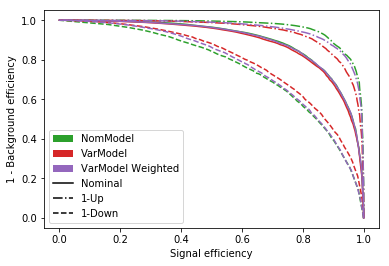

In [17]:
roc(test_df, nommodel, varmodel, varmodelw)

## Cut Optimization

To find the optimal cut values on the output of the classifier, we compute the signficance

\begin{align}
    Z = \frac{s}{\sqrt{b}}
\end{align}

where $s$ and $b$ are the numbers of signal and background events, respectively. The significance is computed as a function of the cut values.

In [18]:
def draw_cut_opt(df, model, model_name, color, incl_syst=False):
    """
    The model computes and plots the expected significe as defined above as a
    function of the cut position.
    
    If the optional argument 'incl_syst' is true, the yield change of the
    systematic variation is factored into the calculation.
    
    The model argument must be a tuple of the actual keras model and the
    normalization moments. This method selects the input variables based on the
    global 'input_var' variables and normalizes the inputs.
    
    The argument model_name is used for the legend.
    
    The color argument sets the color of the line and the optimal cut.
    
    The method returns the position of the optimal cut.
    """
    # Extract model and normalization moments
    model, model_norm = model

    # Apply normalization
    in_df = df[input_var]
    in_df = normalize(in_df, *model_norm)
    
    cut_pos = [0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
    
    # Get events counts per output bin
    sig, bins = np.histogram(model.predict(in_df[df.is_signal & ~df.is_variation]).transpose()[0],
             bins=cut_pos)
    bkg, bins = np.histogram(model.predict(in_df[df.is_background & ~df.is_variation]).transpose()[0],
             bins=cut_pos)
    up_bkg, bins = np.histogram(model.predict(in_df[df.is_background & df.is_up]).transpose()[0],
             bins=cut_pos)
    down_bkg, bins = np.histogram(model.predict(in_df[df.is_background & df.is_down]).transpose()[0],
             bins=cut_pos)
    
    # Compute the cumulative event counts
    cum_sig = np.flip(np.flip(sig).cumsum())
    cum_bkg = np.flip(np.flip(bkg).cumsum())
    cum_up_bkg = np.flip(np.flip(up_bkg).cumsum())
    cum_down_bkg = np.flip(np.flip(down_bkg).cumsum())
    
    # Compute the systematic uncertainty envelop
    syst_env = np.max([cum_bkg - cum_up_bkg, cum_bkg - cum_down_bkg], axis=0)
    if not incl_syst:
        syst_env = 0
        
    # Set the signficance to 0 if there are no background events left after cutting
    err = (cum_bkg == 0)
    cum_sig[err] = 0
    cum_bkg[err] = 1
        
    # Compute significance
    Z = cum_sig / np.sqrt(cum_bkg + syst_env**2)
    
    # Find position with highest significance
    max_x = bins[Z.argmax()]
    
    plt.plot(bins[:-1], Z, color=color, label="%s, Z(%.2f)=%.1f" % (model_name, max_x, Z.max()))
    plt.ylabel("Signficance $Z$")
    plt.xlabel("NN Output Cut")
    plt.axvline(max_x, color=color, linestyle=':')
    plt.xlim((0.05, 1))
    plt.legend()
    plt.tight_layout()
    return max_x

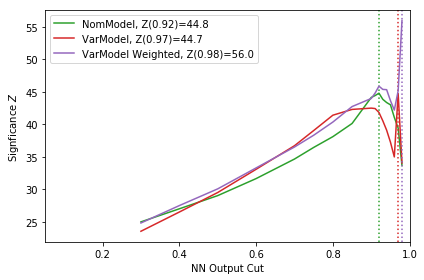

In [19]:
draw_cut_opt(test_df, nommodel, "NomModel", col[2])
draw_cut_opt(test_df, varmodel, "VarModel", col[3])
draw_cut_opt(test_df, varmodelw, "VarModel Weighted", col[4])
plt.savefig("cutopt_stats.pdf")

## Cut optimization with systematics

The optimization of the cut position is repeated by taking the sytematic uncertainty into account. The systematic uncertainty propagates to the signal region and shows up as a difference in yield $\Delta = \max \{|b - b^{\mathrm{up}}|, |b - b^{\mathrm{down}}|\}$ where $b$ and $b^{\mathrm{up}, \mathrm{down}}$ are the number of nominal background events and the number of varied background events after the cut on the output of the classifier. As a simple approximation, we can quadratically add the Poisson uncertainty of the background and the uncertainty from the yield difference. The modified significance is

\begin{align}
    Z = \frac{s}{\sqrt{b + \Delta^2}}.
\end{align}

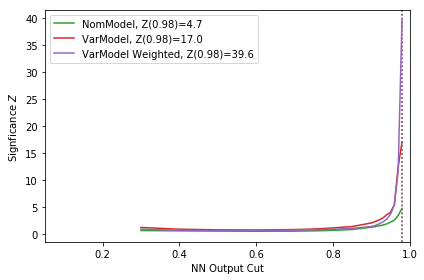

In [20]:
nom_cut = draw_cut_opt(test_df, nommodel, "NomModel", col[2], incl_syst=True)
var_cut = draw_cut_opt(test_df, varmodel, "VarModel", col[3], incl_syst=True)
varw_cut = draw_cut_opt(test_df, varmodelw, "VarModel Weighted", col[4], incl_syst=True)
plt.savefig("cutopt_syst.pdf")

## Signficance

Finally, the significance in the signal region with the optimal cut on the output of the classifier is studied.

In [21]:
def print_stat(df, selection_name): 
    """
    Prints statistical information about the event classes in the given
    dataframe. The method also plots stacked, single-bin histograms of the
    dataframe for the nominal background and the varied background.
    
    The selection_name is used to generated the filename of the plot.
    """
    background = df[df.is_background & ~df.is_variation]
    signal = df[df.is_signal & ~df.is_variation]
    up_background = df[df.is_background & df.is_up]
    up_signal = df[df.is_signal & df.is_up]
    down_background = df[df.is_background & df.is_down]
    down_signal = df[df.is_signal & df.is_down]
    
    s = len(signal)
    b = len(background)
    s_up = len(up_signal)
    b_up = len(up_background)
    s_down = len(down_signal)
    b_down = len(down_background)
    
    ymax = max(s + b, s_up + b_up, s_down + b_down) * 1.3
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    
    bins = [0, 1, 2, 3]
    
    # Nominal
    plt.hist([background.x * 0 + 1, signal.x * 0 + 1], bins=bins, stacked=True, color=col[:2], alpha=0.4)
    # Down
    plt.hist([down_background.x * 0 + 0, down_signal.x * 0 + 0], bins=bins, stacked=True, histtype='step', linestyle="--", color=col[:2])
    # Up
    plt.hist([up_background.x * 0 + 2, up_signal.x * 0 + 2], bins=bins, stacked=True, histtype='step', linestyle="-.", color=col[:2])
    
    leg_bkg = Patch(facecolor=col[0], alpha=0.4, label='Background')
    leg_sig = Patch(facecolor=col[1], alpha=0.4, label='Signal')
    leg_up = Line2D([0], [0], color='black', linestyle='-.', label="1-Up")
    leg_down = Line2D([0], [0], color='black', linestyle='--', label="1-Down")
    plt.legend(handles=[leg_sig, leg_bkg, leg_up, leg_down])
    
    plt.ylim((0, ymax))
    plt.xticks([0.5, 1.5, 2.5], ["1-down", "nominal", "1-up"])
    plt.tight_layout()
    plt.savefig("signal_region_%s.pdf" % selection_name)
    
    syst_env = abs(max(b - b_up, b - b_down))
    Z_syst = len(signal) / math.sqrt(b + syst_env**2)
    
    data = []
    data.append(["Signal:", s, "(%4d, %4d)" % (-s + s_down, -s + s_up)])
    data.append(["Background:", b, "(%4d, %4d)" % (-b + b_down, -b + b_up)])
    data.append(["Significance", "%.2f" % Z_syst])
    
    display(HTML(tabulate.tabulate(data, tablefmt='html')))

### Manual cut on x

As a benchmark, let's look at a manual cut on $x$. The cut value is optimal on the nominal sample.

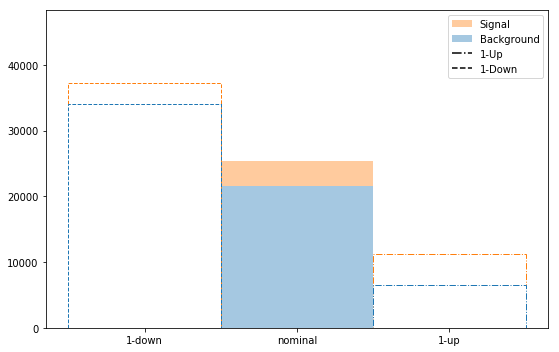

In [22]:
is_selected = test_df.x > 50 - 15 / 2
print_stat(test_df[is_selected], "manual")

### NomModel

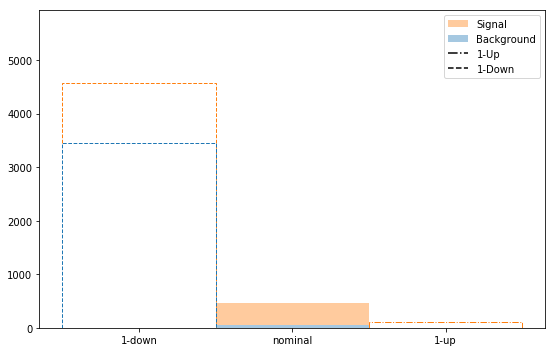

In [23]:
model, norm = nommodel
in_df = test_df[input_var]
in_df = normalize(in_df, *norm)

is_selected = model.predict(in_df).transpose()[0] > nom_cut

print_stat(test_df[is_selected], "nommodel")

### VarModel

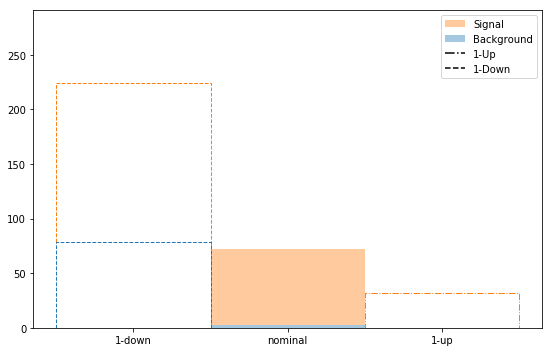

In [24]:
model, norm = varmodel
in_df = test_df[input_var]
in_df = normalize(in_df, *norm)

is_selected = model.predict(in_df).transpose()[0] > var_cut

print_stat(test_df[is_selected], "varmodel")

### VarModel Weighted

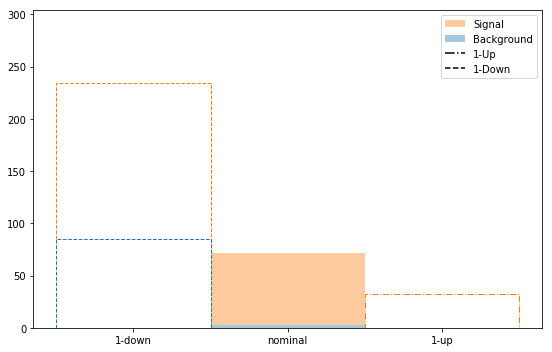

In [25]:
modelw, norm = varmodelw
in_df = test_df[input_var]
in_df = normalize(in_df, *norm)

is_selected = model.predict(in_df).transpose()[0] > varw_cut

print_stat(test_df[is_selected], "varmodel weighted")

## Conclusion
With this toy model, it could be demonstrated that including systematicly varied events during the training can be beneficial if the variation affects background and signal differently.

# Caveats
The significance calculation does not account for the variation of the  signal. The significance is a measure for

\begin{align}
    P(n | b) = \textrm{How likely is it to get n events given b expected events.}
\end{align}

The current method measures how many standard deviations the observed number of events $n$ (here: asimov, i.e., $n=s+b$) is away from the expected number. The exptected number of events comes with the Poisson uncertainty $b$ and the systematic uncertainty $\Delta$ from the variation.

\begin{align}
    \sigma(b)^2 = b + \Delta^2
\end{align}

How can the uncertainty on the signal affect the significance? For an asimov dataset an unceratinty on $s$ affects only $n$ and not the background-only hypothesis. Should this be accounted for via expected significance bands?